In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

fee = 1.53e-4
padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 1000
adam_lr = 1e-1
log_freq = 5

In [3]:
picked_assets = [
    'MPWR',
    'FICO',
    'MTD',
    'NVR',
    'BKNG',
    'ESS',
    'ZBRA',
    'POOL',
    'AIZ',
    'TDY',
    'AMP',
    'FDS',
    'WAT'
]

Loading features: 0it [00:00, ?it/s]


cmf_dim: 126, asset_dim: 5, num_assets: 13


  0%|          | 0/1000 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  0%|          | 4/1000 [02:03<8:10:05, 29.52s/it] 

Sharpe Ratio for the epoch: 1.1298
Average Weights:



,Weight
FICO,1.000000e+00
Cash,6.695507e-09
FDS,8.558654e-11
AMP,1.486926e-11
BKNG,1.160785e-11
NVR,9.909682e-12
ESS,9.892493e-12
WAT,9.840097e-12
TDY,9.824037e-12
MTD,9.820901e-12


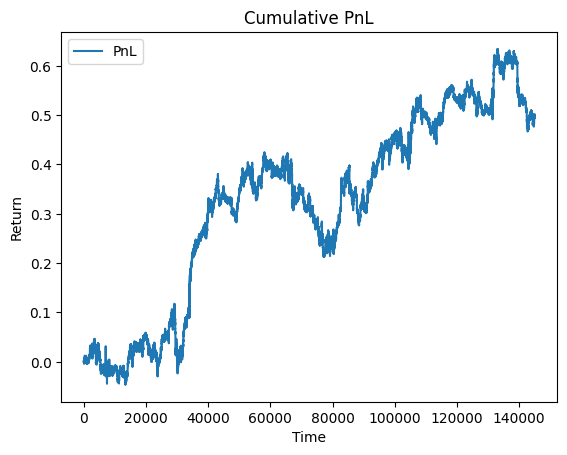

Sharpe Ratio for the epoch: 0.6543
Average Weights:



,Weight
FICO,1.000000e+00
Cash,6.728026e-09
FDS,8.204862e-11
AMP,1.414510e-11
BKNG,1.105620e-11
NVR,9.439018e-12
ESS,9.422777e-12
WAT,9.373288e-12
TDY,9.358046e-12
MTD,9.355103e-12


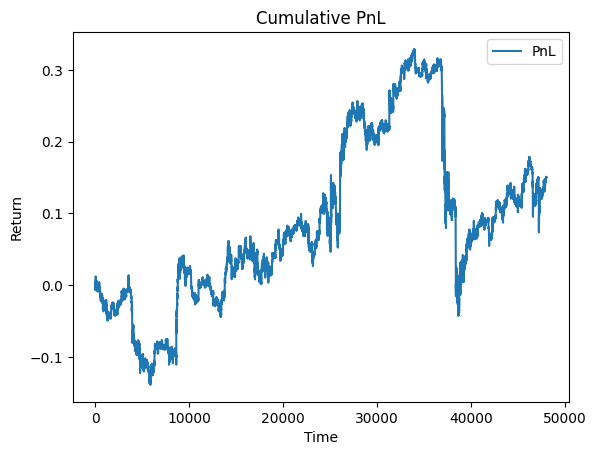

  1%|          | 9/1000 [04:29<8:02:05, 29.19s/it]

Sharpe Ratio for the epoch: 1.1298
Average Weights:



,Weight
FICO,1.000000e+00
Cash,6.716480e-09
FDS,8.558093e-11
AMP,1.486908e-11
BKNG,1.160767e-11
NVR,9.909503e-12
ESS,9.892314e-12
WAT,9.839928e-12
TDY,9.823867e-12
MTD,9.820735e-12


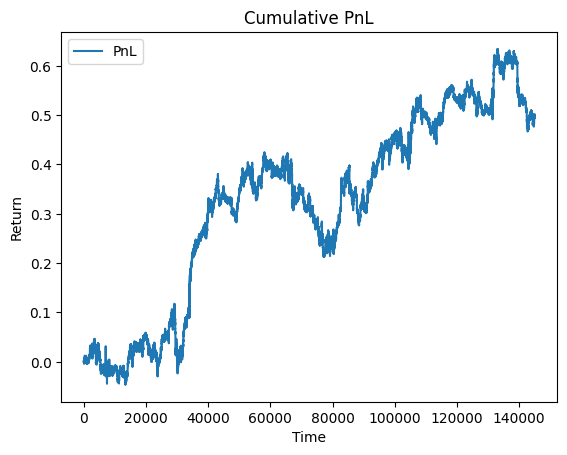

Sharpe Ratio for the epoch: 0.6543
Average Weights:



,Weight
FICO,1.000000e+00
Cash,6.750227e-09
FDS,8.204279e-11
AMP,1.414491e-11
BKNG,1.105601e-11
NVR,9.438834e-12
ESS,9.422593e-12
WAT,9.373111e-12
TDY,9.357865e-12
MTD,9.354924e-12


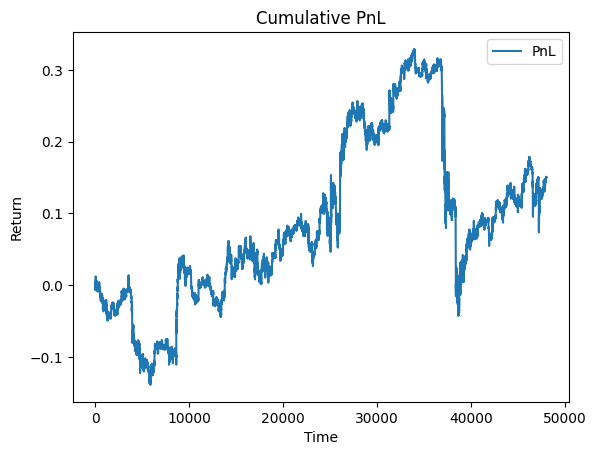

  1%|▏         | 14/1000 [06:53<7:55:05, 28.91s/it]

Sharpe Ratio for the epoch: 1.1298
Average Weights:



,Weight
FICO,1.000000e+00
Cash,6.751106e-09
FDS,8.556997e-11
AMP,1.486854e-11
BKNG,1.160720e-11
NVR,9.909061e-12
ESS,9.891870e-12
WAT,9.839499e-12
TDY,9.823434e-12
MTD,9.820304e-12


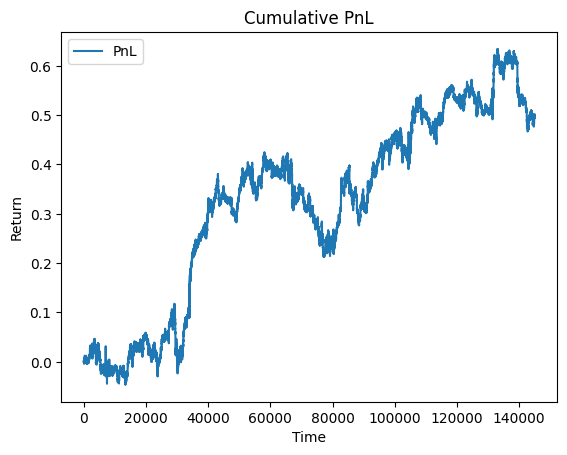

Sharpe Ratio for the epoch: 0.6543
Average Weights:



,Weight
FICO,1.000000e+00
Cash,6.786481e-09
FDS,8.203162e-11
AMP,1.414435e-11
BKNG,1.105553e-11
NVR,9.438386e-12
ESS,9.422142e-12
WAT,9.372675e-12
TDY,9.357430e-12
MTD,9.354489e-12


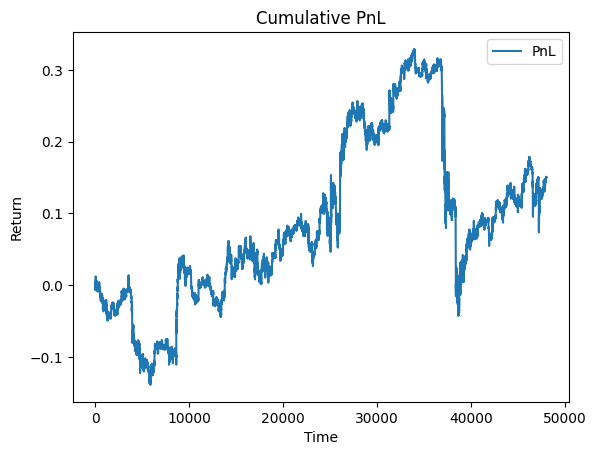

  2%|▏         | 17/1000 [08:20<7:54:53, 28.99s/it]

In [ ]:
batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = len(picked_assets) # asset_feats.shape[1]
    break

print(f"cmf_dim: {cmf_dim}, asset_dim: {asset_dim}, num_assets: {num_assets}")

model = DeepPortfolioAllocator_1(
    cmf_dim=cmf_dim,
    asset_dim=asset_dim,
    num_assets=num_assets,
)

# model = SimplePortfolioAllocator(
#     cmf_dim=cmf_dim,
#     #asset_dim=asset_dim,
#     num_assets=num_assets,
# )

optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs)):
    if epoch in batch_size_config:
        print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
        batch_size = batch_size_config[epoch]
        pipeline = FeaturesPipeline(
            path_to_data,
            padding=padding,
            batch_size=batch_size,
            split_dates=split_dates,
            split_names=split_names
        )

    loss_fn = StreamingSharpeLoss(
        fee=fee,
        asset_names=picked_assets + ['Cash'] # pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        
        fut_ret = fut_ret[picked_assets]  # Фильтруем только по выбранным активам
        min_prices = min_prices[picked_assets]  # Фильтруем только по выбранным активам
        market_caps = market_caps[picked_assets]

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)  # (T, n_assets)
        
        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % log_freq == 0:
        _, weights_df = loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
        weights_df.to_csv(f'weights_epoch_{epoch + 1}.csv')  # Сохраняем веса в CSV
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

        fut_ret = fut_ret[picked_assets]  # Фильтруем только по выбранным активам
        min_prices = min_prices[picked_assets]
        market_caps = market_caps[picked_assets]

        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

        if  len(common_feats) != batch_size:
            continue

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()

In [ ]:
interesting_assets = ['BKNG', 'FICO', 'GWW', 'AZO']

dct = {}

for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):
    common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
    asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
    fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
    min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
    market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)

    if len(common_feats) != batch_size:
        continue

    weights = model(common_feats, asset_feats)
    
    for hor in [1, 5, 10, 20, 60]:
        fut_ret_hor = pd.DataFrame(
            fut_ret.detach().cpu().numpy(),
            columns=pipeline.reader.asset_names
        ).shift(-hor).reset_index(drop=True)

        weights_df = pd.DataFrame(
            weights.detach().cpu().numpy()[:, :-1],  # Убираем Cash
            columns=pipeline.reader.asset_names
        )

        weights_df = weights_df[fut_ret_hor.isna().sum(axis=1) == 0]  # Убираем активы, для которых нет будущих доходностей
        fut_ret_hor = fut_ret_hor[fut_ret_hor.isna().sum(axis=1) == 0]

        for asset in interesting_assets:
            if hor not in dct:
                dct[hor] = {}
            if asset not in dct[hor]:
                dct[hor][asset] = {}
            
            if 'weights' not in dct[hor][asset]:
                dct[hor][asset]['weights'] = []
                dct[hor][asset]['fut_ret'] = []

            dct[hor][asset]['weights'].extend(weights_df[asset].tolist())
            dct[hor][asset]['fut_ret'].extend(fut_ret_hor[asset].tolist())

    #         print(f'For asset {asset} at horizon {hor} minutes: Corr = '
    #               f'{weights_df[asset].corr(fut_ret_hor[asset]):.4f})')
    #     print()
    # print()
dct

{1: {'BKNG': {'weights': [0.16442978382110596,
    0.02194208651781082,
    0.21527691185474396,
    0.1949617862701416,
    0.09318862110376358,
    0.12841227650642395,
    0.05433095991611481,
    0.027566658332943916,
    0.05343879386782646,
    0.11364799737930298,
    0.02651677280664444,
    0.05344570055603981,
    0.05119584500789642,
    0.005405851174145937,
    0.2031354010105133,
    0.08682043850421906,
    0.11399022489786148,
    0.11715784668922424,
    0.0815720334649086,
    0.15345562994480133,
    0.047921981662511826,
    0.055081527680158615,
    0.005914127454161644,
    0.01362829003483057,
    0.012531246989965439,
    0.02177036926150322,
    0.0050817527808249,
    0.022087642922997475,
    0.0028341743163764477,
    0.018621545284986496,
    0.00025771415675990283,
    0.013876824639737606,
    0.012211414985358715,
    0.07246901094913483,
    0.03908181190490723,
    0.03939085826277733,
    0.10840768367052078,
    0.020003212615847588,
    0.0034329711

In [ ]:
for hor in dct:
    print(f'Horizon: {hor} minutes')
    for asset in interesting_assets:
        if asset in dct[hor]:
            weights = dct[hor][asset]['weights']
            fut_ret = dct[hor][asset]['fut_ret']
            if len(weights) > 0 and len(fut_ret) > 0:
                corr = pd.Series(weights).corr(pd.Series(fut_ret))
                print(f'Asset: {asset}, Correlation: {corr:.4f}')
            else:
                print(f'Asset: {asset}, No data available')
    print()
    print('-' * 40)


Horizon: 1 minutes
Asset: BKNG, Correlation: 0.0514
Asset: FICO, Correlation: 0.0581
Asset: GWW, Correlation: 0.0518
Asset: AZO, Correlation: 0.0414

----------------------------------------
Horizon: 5 minutes
Asset: BKNG, Correlation: 0.0098
Asset: FICO, Correlation: 0.0178
Asset: GWW, Correlation: -0.0016
Asset: AZO, Correlation: 0.0144

----------------------------------------
Horizon: 10 minutes
Asset: BKNG, Correlation: 0.0050
Asset: FICO, Correlation: 0.0083
Asset: GWW, Correlation: 0.0009
Asset: AZO, Correlation: -0.0028

----------------------------------------
Horizon: 20 minutes
Asset: BKNG, Correlation: 0.0024
Asset: FICO, Correlation: 0.0049
Asset: GWW, Correlation: 0.0014
Asset: AZO, Correlation: -0.0011

----------------------------------------
Horizon: 60 minutes
Asset: BKNG, Correlation: 0.0011
Asset: FICO, Correlation: 0.0004
Asset: GWW, Correlation: -0.0027
Asset: AZO, Correlation: 0.0003

----------------------------------------
